<a href="https://colab.research.google.com/github/pyagoubi/Credit-Default-Prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%%capture
!pip install bt

torch.Size([7684, 1])
Epoch 1/1000, Train Loss: 0.2405, Validation Loss: 0.0261
torch.Size([7684, 1])
Epoch 2/1000, Train Loss: 0.1629, Validation Loss: 0.0834
torch.Size([7684, 1])
Epoch 3/1000, Train Loss: 0.1359, Validation Loss: 0.1277
torch.Size([7684, 1])
Epoch 4/1000, Train Loss: 0.1401, Validation Loss: 0.0682
torch.Size([7684, 1])
Epoch 5/1000, Train Loss: 0.1096, Validation Loss: 0.0342
torch.Size([7684, 1])
Epoch 6/1000, Train Loss: 0.0968, Validation Loss: 0.0210
torch.Size([7684, 1])
Epoch 7/1000, Train Loss: 0.0772, Validation Loss: 0.0145
torch.Size([7684, 1])
Epoch 8/1000, Train Loss: 0.0375, Validation Loss: 0.0145
torch.Size([7684, 1])
Epoch 9/1000, Train Loss: 0.0349, Validation Loss: 0.0043
torch.Size([7684, 1])
Epoch 10/1000, Train Loss: 0.0132, Validation Loss: 0.0657
torch.Size([7684, 1])
Epoch 11/1000, Train Loss: 0.0350, Validation Loss: 0.0584
torch.Size([7684, 1])
Epoch 12/1000, Train Loss: 0.0290, Validation Loss: 0.0171
torch.Size([7684, 1])
Epoch 13/1000, 

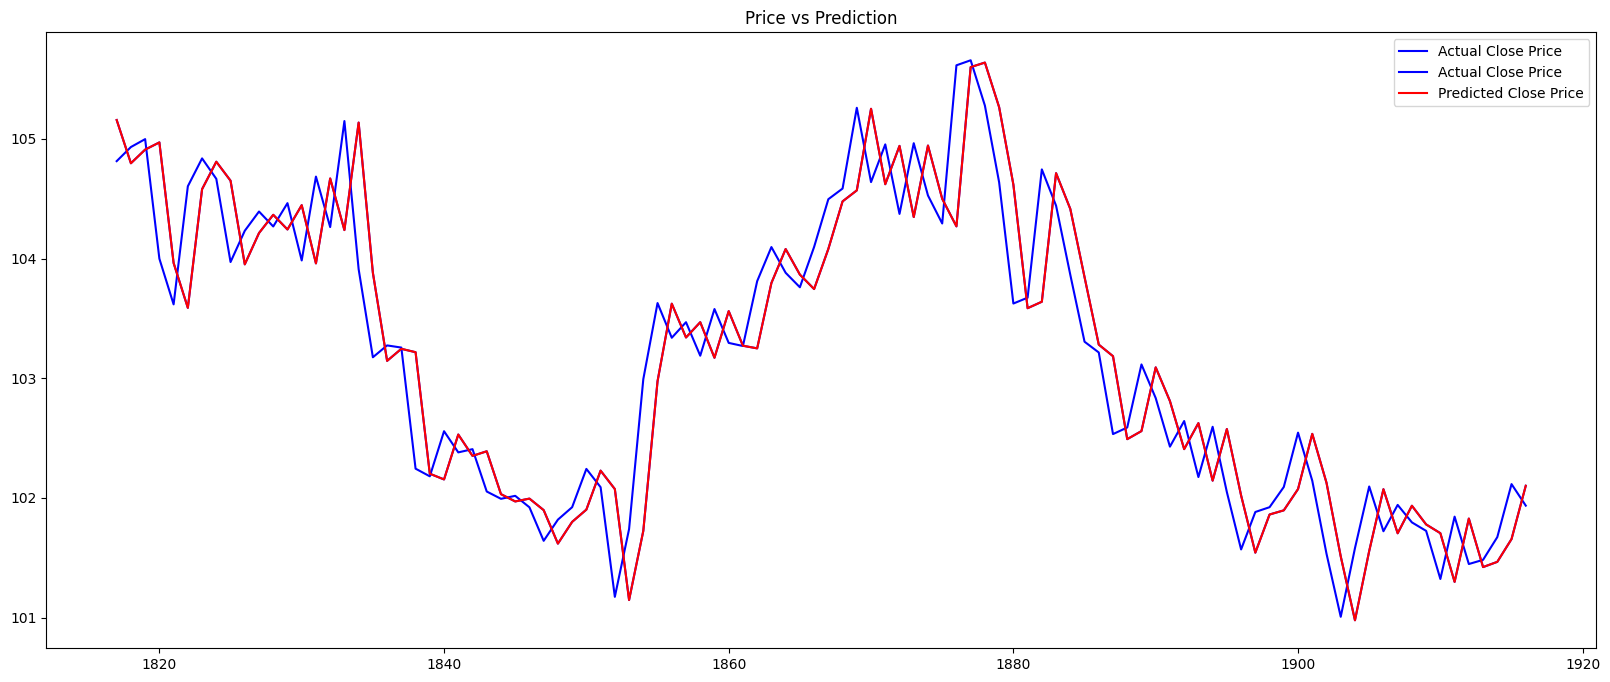

In [67]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
#import bt as bt
import os, sys, itertools, urllib, io
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset

# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

split_fraction = 0.8
time_steps = 5 # number of predictor timesteps
horizon = 1 # number of timesteps to be predicted
sequence_length = time_steps + horizon # determine sequence length
learning_rate=0.01
num_epochs=1000


data_raw = pd.read_csv('/content/drive/MyDrive/stock predict/technical/1D_technical.csv')
#features = ['open', 'high', 'low', 'close', 'rsi', 'adx', 'cci', 'ema', 'stoch', 'trend_macd', 'momentum_stoch', 'volatility_atr']
cols = ['time','close']
features = ['close']
input_size = len(features)
data = data_raw[features].copy()

#data = data[['close']].copy()

split_row = int(data.shape[0] * split_fraction)

train_data = data.iloc[:split_row].copy()
valid_data = data.iloc[split_row:].copy()

f_scaler = MinMaxScaler(feature_range=(-1, 1))
t_scaler = MinMaxScaler(feature_range=(-1, 1))

if input_size == 2:
  train_data.loc[:, train_data.columns != 'close'] = f_scaler.fit_transform(train_data.loc[:, train_data.columns != 'close'].values.reshape(-1,1))
  valid_data.loc[:, valid_data.columns != 'close'] = f_scaler.transform(valid_data.loc[:, valid_data.columns != 'close'].values.reshape(-1,1))
elif input_size >2:
  train_data.loc[:, train_data.columns != 'close'] = f_scaler.fit_transform(train_data.loc[:, train_data.columns != 'close'])
  valid_data.loc[:, valid_data.columns != 'close'] = f_scaler.fit_transform(valid_data.loc[:, valid_data.columns != 'close'])

train_data['close'] = t_scaler.fit_transform(train_data['close'].values.reshape(-1,1))
valid_data['close'] = t_scaler.transform(valid_data['close'].values.reshape(-1,1))

def create_sequences(df, seq_length):
    df = df.values  # Convert DataFrame to numpy array
    
    n = df.shape[0]
    xs = np.zeros((n - seq_length, seq_length, df.shape[1]))
    ys = np.zeros((n - seq_length, 1))
    
    for i in range(n - seq_length):
        xs[i] = df[i:(i+seq_length)]
        ys[i] = df[i+seq_length, -1]  # predict the 'return' column one step ahead
    
    # Convert to PyTorch tensors
    X = torch.from_numpy(xs)
    y = torch.from_numpy(ys)
    
    return X, y
train_data, train_target = create_sequences(train_data, sequence_length)
valid_data, valid_target = create_sequences(valid_data, sequence_length)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):

      super(LSTM, self).__init__()
      
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)    
      self.fc1 = nn.Linear(hidden_size, 10)
      self.fc2 = nn.Linear(10, output_size)  # Add a second layer

      self.tanh = nn.Tanh()

    def forward(self, x):

      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 

      h0.requires_grad = True
      c0.requires_grad = True

      out, _ = self.lstm(x, (h0.detach(), c0.detach()))
      out = self.tanh(self.fc1(out[:, -1, :]))  # apply tanh activation function to the output of the first linear layer
      out = self.fc2(out)  # pass through the second linear layer
    

      # out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
      # out = self.fc1(out[:, -1, :])
      # out = self.tanh(out) 
   
      return out

def train(model, train, train_target, valid, valid_target, learning_rate, num_epochs):

  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []

  train = train.float().to(device)  # Convert to float
  train_target = train_target.float().to(device)  # Convert to float
  valid = valid.float().to(device)  # Convert to float
  valid_target = valid_target.float().to(device)  # Convert to float

  best_loss = float('inf')

  for epoch in range(num_epochs):

    model.train()
    y_train_pred = model(train)

    print(y_train_pred.shape)
    train_loss = criterion(y_train_pred, train_target)
    optimiser.zero_grad()
    train_loss.backward()
    optimiser.step()

    model.eval()
    outputs = model(valid)
    val_loss = criterion(outputs, valid_target)

    print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss.item():.4f}, '
              f'Validation Loss: {val_loss.item():.4f}')
    
    if val_loss < best_loss:
      best_loss = val_loss
      torch.save(model, '/content/drive/MyDrive/stock predict/prediction_model.pt')

num_features = train_data.shape[-1]  # X is your input data
model = LSTM(input_size=input_size, hidden_size=50, num_layers=2, output_size=1)
model = model.to(device)
train(model, train_data, train_target, valid_data, valid_target, learning_rate, num_epochs=num_epochs)


#load best model
model = torch.load('/content/drive/MyDrive/stock predict/prediction_model.pt')
model = model.to(device)
model.eval()
valid_data = valid_data.float().to(device) # Convert to float
val_pred = model(valid_data)

actuals = pd.DataFrame(t_scaler.inverse_transform(valid_target.detach().cpu().numpy()))
preds = pd.DataFrame(t_scaler.inverse_transform(val_pred.detach().cpu().numpy()))


valid = actuals
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.title('Price vs Prediction')
plt.plot(valid[len(valid)-100:], color = 'blue', label = 'Actual Close Price')
plt.plot(valid[len(valid)-100:]['Predictions'], color = 'red', label = 'Predicted Close Price')
plt.legend()
plt.show()



In [53]:
start = pd.to_datetime(data_raw['time'].min())
end = pd.to_datetime(data_raw['time'].max())

In [55]:
symbols = ['AAPL', 'TSLA', 'META']

In [66]:
import yfinance as yf
import pandas as pd

symbols = ['^GSPC']
start = pd.to_datetime(data_raw['time'].min())
end = pd.to_datetime(data_raw['time'].max())

symb_df = pd.DataFrame()

for symbol in symbols:
    # retrieve market data of current ticker symbol
    symbol_data = yf.download(symbol, start=start, end=end)

    # collect the adjusted daily closing price of current ticker symbol
    symb_df[symbol] = symbol_data['Adj Close']

print(symb_df.shape)

[*********************100%***********************]  1 of 1 completed
(9443, 1)


In [64]:
data_raw

,^GSPC
Date,
1985-11-08,193.720001
1985-11-11,197.279999
1985-11-12,198.080002
1985-11-13,197.100006
1985-11-14,199.059998
...,...
2023-04-25,4071.629883
2023-04-26,4055.989990
2023-04-27,4135.350098


In [ ]:

# #################
# from torch.utils.data import Dataset

# class SequenceDataset(Dataset):
#     def __init__(self, sequences, targets):
#         self.sequences = sequences
#         self.targets = targets

#     def __len__(self):
#         return len(self.targets)

#     def __getitem__(self, idx):
#         return self.sequences[idx], self.targets[idx]

# ##############

# def train(model, train, train_target, valid, valid_target, learning_rate, num_epochs):

#   criterion = torch.nn.MSELoss(reduction='mean')
#   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#   hist = np.zeros(num_epochs)
#   start_time = time.time()
#   lstm = []

#   train_dataset = SequenceDataset(train, train_target)
#   val_dataset = SequenceDataset(valid, valid_target)

#   train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#   val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



#   train_losses = []
#   val_losses = []

#   best_loss = float('inf')

#   for epoch in range(num_epochs):

#     model.train()
#     train_epoch_losses = []
#     for sequences, targets in train_loader:
#         sequences = sequences.float().to(device)  # Convert to float
#         targets = targets.float().to(device)  # Convert to float


#         # Forward pass
#         outputs = model(sequences)

#         loss = criterion(outputs, targets)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_epoch_losses.append(loss.item())

#     model.eval()
#     val_epoch_losses = []
#     with torch.no_grad():
#         for sequences, targets in val_loader:
#             sequences = sequences.float().to(device)  # Convert to float
#             targets = targets.float().to(device)  # Convert to float


#             outputs = model(sequences)
#             loss = criterion(outputs, targets)
#             val_epoch_losses.append(loss.item())

#     train_loss = np.mean(train_epoch_losses)
#     val_loss = np.mean(val_epoch_losses)
        
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
             
#     print(f'Epoch {epoch+1}/{num_epochs}, '
#               f'Train Loss: {train_loss:.4f}, '
#               f'Validation Loss: {val_loss:.4f}')
